# Build and test some models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import sql_utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
import pickle
import time
import psycopg2 as pg
%matplotlib inline

/Users/bkhurley/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bkhurley/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# plot in seaborn style
sns.set(font_scale=1.5, style="whitegrid")

In [3]:
# store the figure path for easy plotting to file
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

## Pull the data from postgres

In [4]:
# select and join the BART and weather data from postgres
bart_stn_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='bart_station_info',
                           on1='bart_entry_exit.station', on2='bart_station_info.abbr')

In [5]:
bart_stn_df.head()

,id,date,hour,direction,station,entries,exits,day,month,index,abbr,address,city,county,gtfs_latitude,gtfs_longitude,name,state,zipcode,wu_loc_abbr
0,0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,0,12TH,1245 Broadway,Oakland,alameda,37.803768,-122.271450,12th St. Oakland City Center,CA,94612,KOAK
1,1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,1,16TH,2000 Mission Street,San Francisco,sanfrancisco,37.765062,-122.419694,16th St. Mission,CA,94110,KSFO
2,2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,2,19TH,1900 Broadway,Oakland,alameda,37.808350,-122.268602,19th St. Oakland,CA,94612,KOAK
3,3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,3,24TH,2800 Mission Street,San Francisco,sanfrancisco,37.752470,-122.418143,24th St. Mission,CA,94110,KSFO
4,4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,5,BALB,401 Geneva Avenue,San Francisco,sanfrancisco,37.721585,-122.447506,Balboa Park,CA,94112,KSFO


In [6]:
# drop redundant columns
bart_stn_df.drop(['exits', 'abbr', 'address', 'city', 'county', 'gtfs_latitude', 
                  'gtfs_longitude', 'name', 'state', 'zipcode'], axis=1, inplace=True)

In [7]:
# now get weather data from db. we will join in pandas
sql_query = '''
    SELECT datestamp, wu_loc_abbr, max_temperature, precipitation, rain FROM weather;
    '''
dbname = 'bart_db'
username = 'bkhurley'
con = None
con = pg.connect(database=dbname, user=username)
# query db and return in a df
weather_df = pd.read_sql_query(sql_query,con)

In [8]:
# merge weather data with BART data
bart_weather_df = pd.merge(left=bart_stn_df, right=weather_df, 
                           left_on=['date', 'wu_loc_abbr'],
                           right_on=['datestamp', 'wu_loc_abbr'])
# remove redundant datestamp col
bart_weather_df.drop(['datestamp'], axis=1, inplace=True)

In [9]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,day,month,index,wu_loc_abbr,max_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,Saturday,1,0,KOAK,53.0,0.08,1
1,2,2011-01-01,0,northbound,19TH,19,Saturday,1,2,KOAK,53.0,0.08,1
2,12,2011-01-01,0,northbound,MCAR,7,Saturday,1,24,KOAK,53.0,0.08,1
3,16,2011-01-01,0,northbound,ROCK,2,Saturday,1,35,KOAK,53.0,0.08,1
4,20,2011-01-01,0,northbound,WOAK,10,Saturday,1,45,KOAK,53.0,0.08,1


-------
## Transform features before feeding to model
Generate some new features, and transform categorical features to binary dummy variables 

In [10]:
# take a look at the current data types
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126069 entries, 0 to 2126068
Data columns (total 13 columns):
id                 int64
date               object
hour               object
direction          object
station            object
entries            int64
day                object
month              object
index              int64
wu_loc_abbr        object
max_temperature    float64
precipitation      float64
rain               int64
dtypes: float64(2), int64(4), object(7)
memory usage: 227.1+ MB


In [11]:
# restrict to only the columns to be used in the models
model_data = bart_weather_df[['hour', 'direction', 'station', 'entries', 
                              'day','month', 'max_temperature', 'rain']]
# remove NaN from data before training
model_data = model_data.loc[(~model_data.isnull().any(axis=1)), :]

 ### Transform categorical features to binary dummy variables

In [12]:
# create a weekday dummy variable
model_data['weekday'] = 0
model_data.loc[model_data['day'].isin([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday'] = 1

In [13]:
# transform direction to binary dummy
model_data['northbound'] = 0
model_data.loc[model_data['direction'] == 'northbound', 'northbound'] = 1
# drop the original categorical feature
model_data.drop('direction', axis=1, inplace=True)

In [14]:
model_data.head()

,hour,station,entries,day,month,max_temperature,rain,weekday,northbound
0,0,12TH,16,Saturday,1,53.0,1,0,1
1,0,19TH,19,Saturday,1,53.0,1,0,1
2,0,MCAR,7,Saturday,1,53.0,1,0,1
3,0,ROCK,2,Saturday,1,53.0,1,0,1
4,0,WOAK,10,Saturday,1,53.0,1,0,1


In [15]:
# treat hour and month as ordinal continuous features
model_data['hour'] = model_data['hour'].astype('int')
model_data['month'] = model_data['month'].astype('int')

In [16]:
# make a separate data set w/ no day name features
no_day_data = model_data.drop(columns='day')

In [17]:
no_day_data.head()

,hour,station,entries,month,max_temperature,rain,weekday,northbound
0,0,12TH,16,1,53.0,1,0,1
1,0,19TH,19,1,53.0,1,0,1
2,0,MCAR,7,1,53.0,1,0,1
3,0,ROCK,2,1,53.0,1,0,1
4,0,WOAK,10,1,53.0,1,0,1


In [18]:
# transform categorical features into binary dummy variables
model_data_binary = pd.get_dummies(model_data)
model_data_binary.head()

,hour,entries,month,max_temperature,rain,weekday,northbound,station_12TH,station_16TH,station_19TH,...,station_SSAN,station_WCRK,station_WOAK,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,0,16,1,53.0,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,19,1,53.0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,7,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,2,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,10,1,53.0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [19]:
# also get dummies for the no-day data
no_day_data_binary = pd.get_dummies(no_day_data)
no_day_data_binary.head()

,hour,entries,month,max_temperature,rain,weekday,northbound,station_12TH,station_16TH,station_19TH,...,station_NCON,station_ORIN,station_PHIL,station_POWL,station_ROCK,station_SBRN,station_SFIA,station_SSAN,station_WCRK,station_WOAK
0,0,16,1,53.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,19,1,53.0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,7,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,53.0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,10,1,53.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Before submitting to a model, check for multicolinearity among features

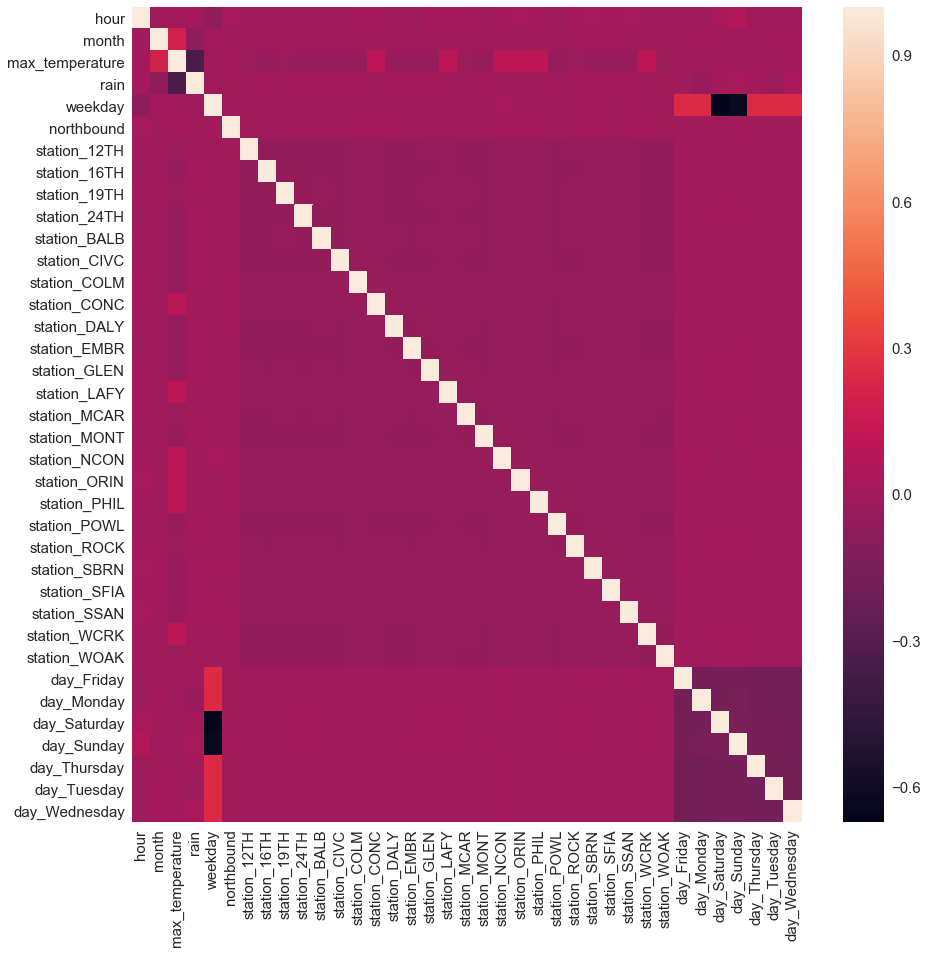

In [22]:
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr())

None of the features look alarmingly correlated with one another. May consider trying a model with day names only and another with weekend/weekday only & see if either fit any better or worse than model containing both.

-------
# Linear Regression
Train regression models to predict passenger crowding using the above features. 

In [23]:
y = model_data_binary['entries']
X = model_data_binary.drop('entries', axis=1)

In [24]:
y_noday = no_day_data_binary['entries']
X_noday = no_day_data_binary.drop('entries', axis=1)

## Least-squares regression
First, use a simple *ordinary least-squares (OLS) regression* model

#### Partition data for validation
Partition into 80% training set and 20% test set. 

In [44]:
#X = model_data_binary.drop('entries', axis=1) # features = all columns except 'entries'
#y = model_data_binary['entries']

In [24]:
#scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
#ols_reg = LinearRegression()
#scores = cross_validate(ols_reg, X, y, scoring=scoring,
#                        cv=5, return_train_score=False)

In [25]:
#sorted(scores.keys())

['fit_time',
 'score_time',
 'test_neg_mean_absolute_error',
 'test_neg_mean_squared_error',
 'test_r2']

In [42]:
#print('Avg CV model scores:')
#print('MAE:', abs(np.mean(scores['test_neg_mean_absolute_error'])))
#print('MSE:', abs(np.mean(scores['test_neg_mean_squared_error'])))
#print('RMSE:', np.sqrt(abs(np.mean(scores['test_neg_mean_squared_error']))))
#print('R^2: ', np.mean(scores['test_r2']))

Avg CV model scores:
MAE: 157.920632251
MSE: 79311.2538647
RMSE: 281.62253792
R^2:  0.16983408676


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [28]:
# do train test split on data w/ no day names
X_train_noday, X_test_noday, y_train_noday, y_test_noday = train_test_split(X_noday, y_noday, test_size=0.2, random_state=5)

### Train model
Fit an OLS regression model to the training data

In [53]:
ols_reg = LinearRegression()
ols_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate model predictions

In [54]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

In [55]:
predicted = ols_reg.predict(X_test)

In [56]:
#predicted = cross_val_predict(ols_reg, X, y, cv=5)

In [57]:
print('R2 for OLS Regression: %.2f' % metrics.r2_score(y_test, predicted))

R2 for OLS Regression: 0.17


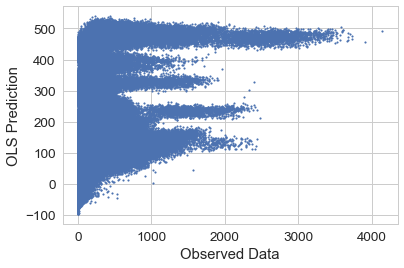

In [58]:
plt.scatter(y_test, predicted, s=3)
plt.xlabel('Observed Data')
plt.ylabel('OLS Prediction')
plt.savefig(figpath + 'ols_predict.png')

Looks like the OLS model is pretty biased and fits poorly. This is likely due to the extreme outliers of the high-volume stations at high-volume times (e.g., downtown SF stations at rushour).

### Evaluate model

In [59]:
print('Accuracy metrics for OLS Regression:')
print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R^2: ', metrics.r2_score(y_test, predicted))

Accuracy metrics for OLS Regression:
MAE: 157.152254004
MSE: 77994.9628304
RMSE: 279.27578275
R^2:  0.169697017805


#### Residuals

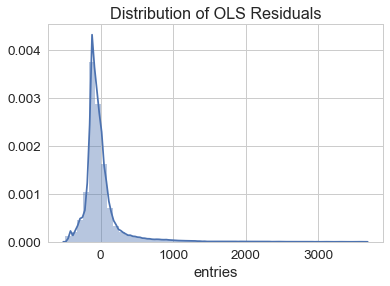

In [60]:
sns.distplot((y_test-predicted),bins=50);
plt.title('Distribution of OLS Residuals')
plt.savefig(figpath + 'ols_resid.png')

In [61]:
# dump model to pickle file so I can pick it up in Flask
with open('ols.pkl', 'wb') as fid:
    pickle.dump(ols_reg, fid,2) 

In [62]:
#For building feature vectors, create a dataframe with the dummy variables
feats = model_data_binary.drop('entries', axis=1)
index_dict = dict(zip(feats.columns,range(feats.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 

## Ridge Regression
OLS did not perform very good. With the one-hot encoding of multi-class categoricals, we ended up with 70+ features. This might lead to an over-fitting to the training data. Let's use a ridge regression to impart some regularization and shrink the less informative features.

### Train model
Fit ridge model under each tuning value, and select best penalty (`alpha`) using cross-validation.  

In [57]:
# define array of tuning values to test
tuning = np.logspace(0, 7, num=15)
# fit ridge model to data using 5-fold CV
ridge = RidgeCV(alphas=tuning, cv=5)

In [193]:
# start timer
start = time.time()

ridge.fit(X, y)

# end timer
end = time.time()
elapsed = end-start
print(str(elapsed/60) + ' minutes elapsed' )

34.65736091931661 minutes elapsed


In [194]:
print('Optimal tuning parameter value: ', ridge.alpha_)

Optimal tuning parameter value:  1000.0


### Evaluate model predictions

In [195]:
ridge_predictions = ridge.predict(X)

In [196]:
print('MSE:', metrics.mean_squared_error(y, ridge_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, ridge_predictions)))
print('R^2: ', ridge.score(X, y))

MSE: 67967.7997637
RMSE: 260.706347763
R^2:  0.288578701692


No improvement in model fit compared to the simple OLS regression. Predictions are still pretty biased, as shown below. Perhaps a polynomial model would improve things.

Text(0,0.5,'Ridge-Predicted Crowd Levels')

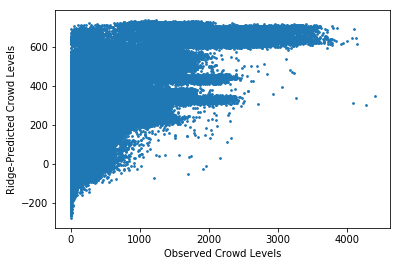

In [198]:
plt.scatter(y, ridge_predictions, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Ridge-Predicted Crowd Levels')

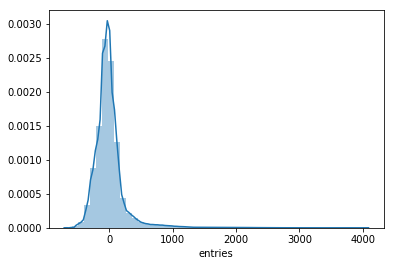

In [199]:
sns.distplot((y-ridge_predictions),bins=50)

## Random Forest Regression

In [25]:
rf_reg = RandomForestRegressor(random_state=5, oob_score=True)

In [46]:
start = time.time()
#grid.fit(X_train, y_train)
rf_reg.fit(X_train, y_train)

In [ ]:
# print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#       % (time() - start, len(grid.cv_results_['params'])))
rf_fit = time.time() - start
print("RF model fitted in %.3f s"
      % rf_fit)

In [30]:
rf_reg_noday = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=5, oob_score=True)

In [32]:
# fit separate RF model for data set w/ day names removed
start = time.time()
rf_reg_noday.fit(X_train_noday, y_train_noday)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=5, verbose=0, warm_start=False)

In [33]:
print("RF model fitted in %.3f s" % (time.time() - start))

RF model fitted in 1275.173 s


### Fit and evaluate model

In [35]:
# prediction for model trained on data w/ no day name
predicted_test_noday = rf_reg_noday.predict(X_test_noday)

In [113]:
print('Accuracy metrics for RF model fitted with weekday (no day name):')
print('MSE:', metrics.mean_squared_error(y_test_noday, predicted_test_noday))
print('MAE:', metrics.mean_absolute_error(y_test_noday, predicted_test_noday))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_noday, predicted_test_noday)))
print('R^2: ', metrics.r2_score(y_test_noday, predicted_test_noday))

Accuracy metrics for RF model fitted with weekday:
MSE: 8691.59246981
MAE: 36.6931494614
RMSE: 93.2287105446
R^2:  0.908321168406


In [140]:
# fit with 100 estimators and 10 minimum leaf samples
print('Accuracy metrics for RF model fitted with weekend (no day name):')
print('MSE:', metrics.mean_squared_error(y_test_noday, predicted_test_noday))
print('MAE:', metrics.mean_absolute_error(y_test_noday, predicted_test_noday))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_noday, predicted_test_noday)))
print('R^2: ', metrics.r2_score(y_test_noday, predicted_test_noday))

Accuracy metrics for RF model fitted with weekend (no day name):
MSE: 7128.20886066
MAE: 32.9573793969
RMSE: 84.4287205912
R^2:  0.924811723286


In [36]:
# fit with 100 estimators and 10 minimum leaf samples and month as continuous
print('Accuracy metrics for RF model fitted with weekend (no day name):')
print('MSE:', metrics.mean_squared_error(y_test_noday, predicted_test_noday))
print('MAE:', metrics.mean_absolute_error(y_test_noday, predicted_test_noday))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test_noday, predicted_test_noday)))
print('R^2: ', metrics.r2_score(y_test_noday, predicted_test_noday))

Accuracy metrics for RF model fitted with weekend (no day name):
MSE: 7118.63030022
MAE: 32.957646325
RMSE: 84.3719757989
R^2:  0.925406724208


Compare these model metrics to the earlier OLS and Ridge regression models. <br>
We see that that the fit with a Random Forest regression is *phenomenally* better.<br>
Explaining 93% of the variance!

Text(0,0.5,'Random Forest Prediction')

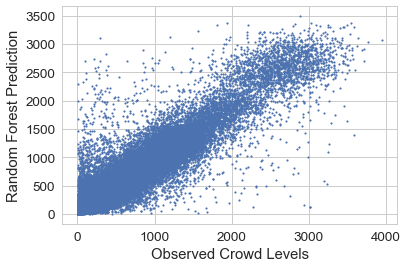

In [89]:
# compare predictions to observed values
plt.scatter(y_test, predicted_test, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Random Forest Prediction')

Text(0.5,1,'RF model w/ no day name features')

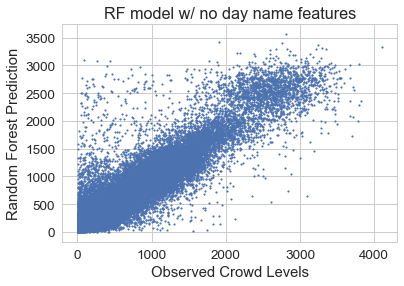

In [114]:
# predictions for data w/ no day names
plt.scatter(y_test_noday, predicted_test_noday, s=3)
plt.xlabel('Observed Crowd Levels')
plt.ylabel('Random Forest Prediction')
plt.title('RF model w/ no day name features')

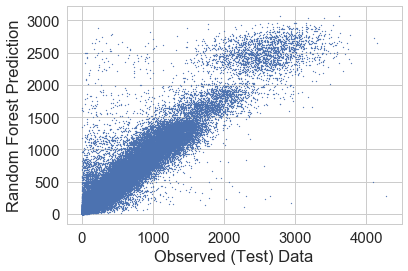

In [76]:
# predictions for data w/ no day names & optimized hyper-params
plt.scatter(y_test_noday, predicted_test_noday, s= 1)
plt.xlabel('Observed (Test) Data')
plt.ylabel('Random Forest Prediction')
plt.savefig(figpath + 'rf_predict.png', bbox_inches='tight')

Text(0.5,1,'Residual Error (RF)')

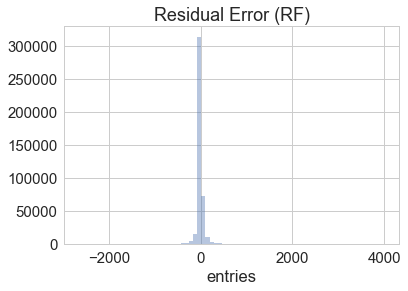

In [45]:
# check out the distribution of residuals
sns.distplot((y_test_noday-predicted_test_noday),bins=75, kde=False)
plt.title('Residual Error (RF)')

We can see from the two above plots that model predictions tightly correspond to the observed data, and prediction error is no longer highly skewed like in the OLS and Ridge Regression models.

### Feature Importance

In [91]:
importances = rf_reg.feature_importances_

In [92]:
std = np.std([importances for tree in rf_reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_featnames = X.columns[indices]

In [100]:
sorted_featnames[0:20]

Index(['hour', 'weekday', 'northbound', 'station_POWL', 'station_MONT',
       'station_EMBR', 'max_temperature', 'station_CIVC', 'station_GLEN',
       'station_DALY', 'station_PHIL', 'station_BALB', 'station_16TH',
       'station_24TH', 'station_WOAK', 'station_COLM', 'station_CONC',
       'station_WCRK', 'station_MCAR', 'station_12TH'],
      dtype='object')

In [93]:
# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, sorted_featnames[f], importances[indices[f]]))

Feature ranking:
1. hour (0.435346)
2. weekday (0.121602)
3. northbound (0.083255)
4. station_POWL (0.039800)
5. station_MONT (0.037868)
6. station_EMBR (0.036732)
7. max_temperature (0.028879)
8. station_CIVC (0.024465)
9. station_GLEN (0.018897)
10. station_DALY (0.016647)
11. station_PHIL (0.016553)
12. station_BALB (0.010712)
13. station_16TH (0.010563)
14. station_24TH (0.008662)
15. station_WOAK (0.008021)
16. station_COLM (0.007868)
17. station_CONC (0.007305)
18. station_WCRK (0.007217)
19. station_MCAR (0.006797)
20. station_12TH (0.005731)
21. station_19TH (0.005707)
22. station_ROCK (0.005422)
23. station_SSAN (0.004859)
24. day_Friday (0.004485)
25. rain (0.003907)
26. station_SBRN (0.003788)
27. station_LAFY (0.003421)
28. station_NCON (0.003022)
29. day_Monday (0.002908)
30. station_SFIA (0.002695)
31. station_ORIN (0.002557)
32. month_11 (0.002449)
33. month_12 (0.002119)
34. day_Thursday (0.001996)
35. day_Wednesday (0.001964)
36. day_Sunday (0.001672)
37. month_1 (0.00

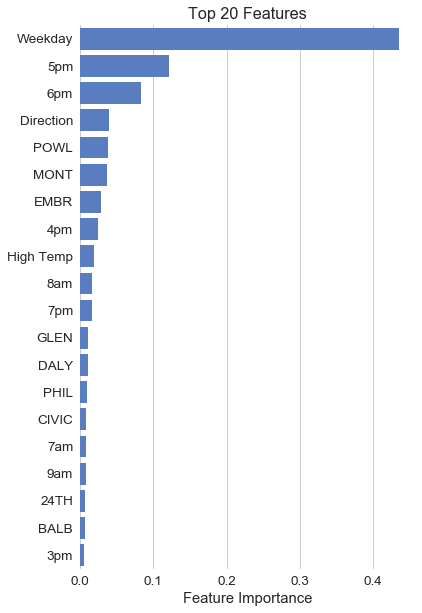

In [95]:
# Plot ranked feature importance
f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes("muted")
featimport = sns.barplot(importances[indices[0:20]], sorted_featnames[0:20],
                         color='b')
featimport.set_yticklabels(['Hour', 'Weekday', 'Direction', 'POWL', 'MONT',
                            'EMBR', 'High Temp', 'CIVC', 'GLEN',
                            'DALY', 'PHIL', '7am', '9am', '24TH', 
                            'BALB', '3pm'])

plt.title('Top 20 Features')
ax.set(xlabel="Feature Importance")
sns.despine(left=True, bottom=True)
plt.savefig(figpath + 'randforest_featimport.png', bbox_inches='tight')


Pickle the model so I can use it to make predictions in m Flask app

In [155]:
# pickle the model for web deployment in Flask
with open('rf_reg.pkl', 'wb') as fid:
    pickle.dump(regr, fid,2) 

In [156]:
#For building feature vectors, create a dataframe with the dummy variables
index_dict = dict(zip(X.columns,range(X.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 

### Repeat feature importance analysis for model not trained on day name feature

In [38]:
importance_noday = rf_reg_noday.feature_importances_

In [39]:
std = np.std([importance_noday for tree in rf_reg.estimators_],
             axis=0)
indices = np.argsort(importance_noday)[::-1]
sorted_featnames = X_noday.columns[indices]

/Users/bkhurley/anaconda/envs/insight/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/bkhurley/anaconda/envs/insight/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/bkhurley/anaconda/envs/insight/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
# Print the feature ranking
print("Feature ranking (optimized hyper-params):")
for f in np.arange(X_noday.shape[1]):
    print("%d. %s (%f)" % (f + 1, sorted_featnames[f], importance_noday[indices[f]]))

Feature ranking (optimized hyper-params):
1. hour (0.457489)
2. weekday (0.128250)
3. northbound (0.086615)
4. station_POWL (0.041749)
5. station_MONT (0.039720)
6. station_EMBR (0.038748)
7. station_CIVC (0.025808)
8. station_GLEN (0.020077)
9. station_PHIL (0.017853)
10. station_DALY (0.017462)
11. station_BALB (0.011299)
12. station_16TH (0.011056)
13. max_temperature (0.009966)
14. station_24TH (0.009114)
15. station_COLM (0.008164)
16. station_WOAK (0.008143)
17. station_CONC (0.007689)
18. station_WCRK (0.007412)
19. station_MCAR (0.007148)
20. station_12TH (0.006038)
21. station_19TH (0.006009)
22. month (0.006005)
23. station_ROCK (0.005750)
24. station_SSAN (0.005193)
25. station_SBRN (0.004012)
26. station_LAFY (0.003525)
27. station_NCON (0.003170)
28. station_SFIA (0.002868)
29. station_ORIN (0.002748)
30. rain (0.000923)


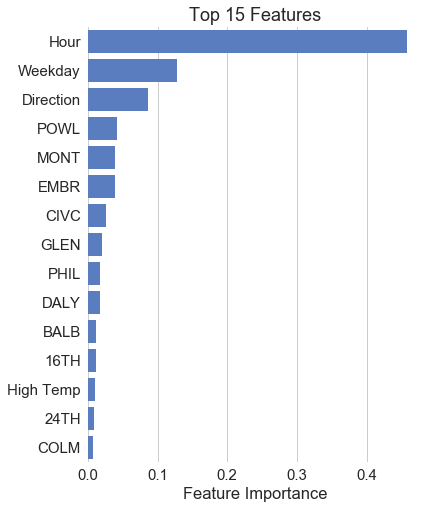

In [41]:
# Plot ranked feature importance
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes("muted")
featimport = sns.barplot(importance_noday[indices[0:15]], sorted_featnames[0:15],
                         color='b')
featimport.set_yticklabels(['Hour', 'Weekday', 'Direction', 'POWL', 'MONT',
                            'EMBR', 'CIVC', 'GLEN', 'PHIL', 'DALY',
                            'BALB', '16TH', 'High Temp', '24TH', 'COLM'])
#                            'COLM', 'WCRK', 'CONC', 'MCAR', '19TH'])

plt.title('Top 15 Features')
ax.set(xlabel="Feature Importance")
sns.despine(left=True, bottom=True)
plt.savefig(figpath + 'randforest_featimport_top15_opt.png', bbox_inches='tight')


In [42]:
# pickle the updated model for web deployment in Flask
with open('rf_reg_updated.pkl', 'wb') as fid:
    pickle.dump(rf_reg_noday, fid,2) 

In [43]:
#For building feature vectors, create a dataframe with the dummy variables
index_dict = dict(zip(X_noday.columns,range(X_noday.shape[1])))
with open('cat_updated.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 